In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
SPLITS = [
    [str(i) for i in range(1, 23) if i % 2 == 1] + ["X"],
    [str(i) for i in range(1, 23) if i % 2 == 0] + ["Y"],
]
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/eqtl/matched/ge"
SPLITS

[['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X'],
 ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']]

In [3]:
models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

embedding_models = models[-1:] + [
    "Enformer",
    #"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA
0,1,14677,G,A,0.992227,0.055024,True,0,-0.370660,-0.452,-0.000,-1.902,-1.095703
1,1,54490,G,A,1.000000,0.159938,True,1,0.201295,0.313,-0.000,-0.029,0.039062
2,1,63671,G,A,0.998592,0.156388,True,2,-0.344458,1.392,-0.000,-0.253,3.130859
3,1,63697,T,C,0.977568,0.195652,True,3,-1.180623,-1.155,-0.701,-2.212,-6.382812
4,1,108826,G,C,1.000000,0.040023,True,4,-0.018075,0.306,-0.000,2.419,-0.430176
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21571,X,155203528,C,T,0.009518,0.279275,False,10692,-0.223889,0.603,-0.003,-0.091,-0.135254
21572,X,155559972,A,T,0.008540,0.279240,False,10678,-1.005496,-1.903,-0.979,-2.056,-5.105469
21573,X,155672303,G,A,0.962191,0.436727,True,10785,-0.082362,-0.075,-0.209,-0.073,2.652344
21574,X,155768650,G,T,0.991784,0.455970,True,10786,-1.179355,-2.212,-1.000,-2.759,7.382812


In [4]:
features = {}

for m in embedding_models:
    df = pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{m}.parquet")
    df.columns = model_renaming.get(m, m) + "_" + df.columns
    if m == "Enformer": df = -df.abs()
    features[model_renaming.get(m, m)] = df.columns.values
    V = pd.concat([V, df], axis=1)
embedding_models = [model_renaming.get(m, m) for m in embedding_models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,CADD,phyloP-100-vertebrates,...,Enformer_feature_5303,Enformer_feature_5304,Enformer_feature_5305,Enformer_feature_5306,Enformer_feature_5307,Enformer_feature_5308,Enformer_feature_5309,Enformer_feature_5310,Enformer_feature_5311,Enformer_feature_5312
0,1,14677,G,A,0.992227,0.055024,True,0,-0.370660,-0.452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,54490,G,A,1.000000,0.159938,True,1,0.201295,0.313,...,-0.000029,-0.000012,-4.172325e-07,-0.000012,-0.000015,-0.000010,-0.000033,-0.000008,-0.000069,-0.000016
2,1,63671,G,A,0.998592,0.156388,True,2,-0.344458,1.392,...,-0.000181,-0.000004,-2.068281e-05,-0.000024,-0.000069,-0.000015,-0.000038,-0.000019,-0.000246,-0.000296
3,1,63697,T,C,0.977568,0.195652,True,3,-1.180623,-1.155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,108826,G,C,1.000000,0.040023,True,4,-0.018075,0.306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21571,X,155203528,C,T,0.009518,0.279275,False,10692,-0.223889,0.603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21572,X,155559972,A,T,0.008540,0.279240,False,10678,-1.005496,-1.903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21573,X,155672303,G,A,0.962191,0.436727,True,10785,-0.082362,-0.075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21574,X,155768650,G,T,0.991784,0.455970,True,10786,-1.179355,-2.212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [6]:
V["Enformer_l2"] = -np.linalg.norm(V[features["Enformer"]], axis=1)
models.append("Enformer_l2")

In [7]:
V.dropna(
    subset=models + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,match_group,CADD,phyloP-100-vertebrates,...,Enformer_feature_5304,Enformer_feature_5305,Enformer_feature_5306,Enformer_feature_5307,Enformer_feature_5308,Enformer_feature_5309,Enformer_feature_5310,Enformer_feature_5311,Enformer_feature_5312,Enformer_l2
1,1,54490,G,A,1.000000,0.159938,True,1,0.201295,0.313,...,-1.150370e-05,-4.172325e-07,-1.150370e-05,-0.000015,-1.013279e-05,-3.349781e-05,-0.000008,-6.866455e-05,-0.000016,-0.039338
2,1,63671,G,A,0.998592,0.156388,True,2,-0.344458,1.392,...,-4.112720e-06,-2.068281e-05,-2.408028e-05,-0.000069,-1.490116e-05,-3.772974e-05,-0.000019,-2.460480e-04,-0.000296,-0.119792
5,1,286747,A,G,1.000000,0.151295,True,5,-0.241201,-0.331,...,-7.152557e-07,-3.576279e-07,-8.344650e-07,-0.000004,-5.960464e-08,-4.172325e-07,-0.000002,-8.344650e-07,-0.000005,-0.016280
7,1,912710,G,A,0.008546,0.222110,False,482,0.326575,1.960,...,-4.446507e-05,-9.179115e-06,-1.966953e-06,-0.000029,-6.496906e-06,-2.324581e-05,-0.000002,-4.231930e-05,-0.000035,-0.041148
8,1,917584,T,G,0.996919,0.199664,True,7,-1.103527,-1.155,...,-1.325607e-04,-3.105402e-05,-1.341105e-05,-0.000134,-2.759695e-05,-8.088350e-05,-0.000015,-3.345013e-04,-0.000270,-0.211533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21047,22,50665387,T,A,0.006481,0.030702,False,10404,-0.022905,0.134,...,-1.010895e-04,-3.516674e-05,-3.951788e-05,-0.000015,-3.576279e-06,-7.748604e-07,-0.000005,-2.491474e-05,-0.000028,-0.017267
21048,22,50665389,G,A,0.006481,0.030702,False,10418,0.072892,0.134,...,-1.335144e-04,-3.892183e-05,-2.944469e-05,-0.000015,-1.668930e-05,-3.397465e-06,-0.000010,-9.024143e-05,-0.000033,-0.025388
21049,22,50733265,G,A,0.971032,0.302632,True,10523,0.542960,0.950,...,-1.680851e-05,-9.357929e-06,-4.822016e-05,-0.000002,-1.490116e-06,-7.748604e-07,-0.000007,-1.788139e-06,-0.000018,-0.033971
21050,22,50783672,G,T,0.964513,0.080189,True,10524,-0.699263,-0.321,...,-1.663208e-02,-3.982544e-03,-1.667976e-03,-0.002495,-1.203537e-03,-2.494812e-03,-0.001231,-1.181030e-02,-0.005753,-1.553370


In [8]:
V = V[V.duplicated("match_group", keep=False)]
V.label.value_counts()

label
True     9304
False    9304
Name: count, dtype: int64

In [9]:
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, roc_auc_score(V_train.label, -V_train[f])]
        for f in tqdm(features)
    ], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', LogisticRegressionCV(
            random_state=42,
            scoring="roc_auc",
            n_jobs=-1,
            max_iter=1000,
            Cs=np.logspace(-5, 0, 10),
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    linear = clf.named_steps["linear"]
    C = linear.C_
    Cs = linear.Cs_
    #if C == Cs[0] or C == Cs[-1]:
    #    raise Exception(f"{C=} {Cs[0]=} {Cs[-1]=}")
    return -clf.predict_proba(V_test[features])[:, 1]

supervised_models = []

for m in embedding_models:
    supervised_models.append((
        f"{m} - best inner product",
        lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    ))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))

supervised_models.append((
    f"GPN-MSA + Enformer - LR(inner products+abs(delta features))",
    lambda *args: train_predict_lr(*args, np.concatenate([features["GPN-MSA"], features["Enformer"]])),
))

for split in SPLITS:
    print(split)
    mask_train = V.chrom.isin(split)
    mask_test = ~mask_train
    for model_name, model in supervised_models:
        print(model_name)
        if model_name not in models: models.append(model_name)
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])

['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X']
GPN-MSA - best inner product


100%|██████████| 768/768 [00:03<00:00, 245.88it/s]


GPN-MSA - LR(inner products)
Enformer - best inner product


100%|██████████| 5313/5313 [00:21<00:00, 245.54it/s]


Enformer - LR(inner products)
GPN-MSA + Enformer - LR(inner products+abs(delta features))


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']
GPN-MSA - best inner product


100%|██████████| 768/768 [00:02<00:00, 271.26it/s]


GPN-MSA - LR(inner products)
Enformer - best inner product


100%|██████████| 5313/5313 [00:19<00:00, 275.89it/s]


Enformer - LR(inner products)
GPN-MSA + Enformer - LR(inner products+abs(delta features))


/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

## Testing

In [10]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC])
results = pd.DataFrame(rows, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

100%|██████████| 11/11 [00:00<00:00, 104.07it/s]


,Model,AUROC
9,Enformer - LR(inner products),0.773701
10,GPN-MSA + Enformer - LR(inner products+abs(del...,0.772318
7,GPN-MSA - LR(inner products),0.729292
8,Enformer - best inner product,0.725077
5,Enformer_l2,0.709572
6,GPN-MSA - best inner product,0.688296
0,CADD,0.575880
4,GPN-MSA,0.538089
3,phyloP-241-mammals,0.527657
1,phyloP-100-vertebrates,0.515029


In [14]:
#results.to_parquet("results_eqtl.parquet", index=False)

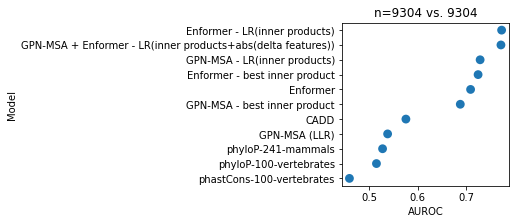

In [12]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);